In [ ]:
import pandas as pd
import os
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import re
import math
import numpy as np

In [2]:
peds = "/Users/aarthimuthukumar/Documents/Medical School/Research Papers/DHT- Surbhi/SNA-R-Analysis/pediatric_data"
adults = "/Users/aarthimuthukumar/Documents/Medical School/Research Papers/DHT- Surbhi/SNA-R-Analysis/adult_data"

all_peds = []
for root, dirs, files in os.walk(peds):
    for filename in files:
        filepath = os.path.join(root, filename)    
        df = pd.read_csv(filepath)
        df["source_file"] = filename
        all_peds.append(df)

peds_df = pd.concat(all_peds, ignore_index=True)


all_adults = []
for root, dirs, files in os.walk(adults):
    for filename in files:
        filepath = os.path.join(root, filename)    
        df = pd.read_csv(filepath)
        df["source_file"] = filename
        all_adults.append(df)

adults_df = pd.concat(all_adults, ignore_index=True)

In [3]:
peds_df.columns

Index(['AGE', 'ADMIT', 'RFV1', 'RFV2', 'RFV3', 'RFV4', 'RFV5', 'RFV1_desc',
       'RFV2_desc', 'RFV3_desc', 'RFV4_desc', 'RFV5_desc', 'MED1', 'MED2',
       'MED3', 'MED4', 'MED5', 'MED6', 'GPMED1', 'GPMED2', 'GPMED3', 'GPMED4',
       'GPMED5', 'GPMED6', 'GPMED7', 'GPMED8', 'GPMED9', 'GPMED10', 'GPMED11',
       'GPMED12', 'GPMED13', 'GPMED14', 'GPMED15', 'GPMED16', 'GPMED17',
       'GPMED18', 'GPMED19', 'GPMED20', 'GPMED21', 'GPMED22', 'GPMED23',
       'GPMED24', 'GPMED25', 'GPMED26', 'GPMED27', 'GPMED28', 'GPMED29',
       'GPMED30', 'CONTSUB1', 'CONTSUB2', 'CONTSUB3', 'CONTSUB4', 'CONTSUB5',
       'CONTSUB6', 'NUMGIV', 'NUMDIS', 'NUMMED', 'CAUSE2', 'CAUSE3', 'PROC',
       'ADMIT_desc', 'PATWT', 'source_file', 'CONTSUB7', 'CONTSUB8',
       'CONTSUB9', 'CONTSUB10', 'CONTSUB11', 'EDWT', 'CAUSE1'],
      dtype='object')

/var/folders/nl/1gjrt7sn5l94pk_8l9cjlnrm0000gn/T/ipykernel_18889/454648050.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_source_age = (meds_long
/var/folders/nl/1gjrt7sn5l94pk_8l9cjlnrm0000gn/T/ipykernel_18889/454648050.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_source_age_type = (meds_long


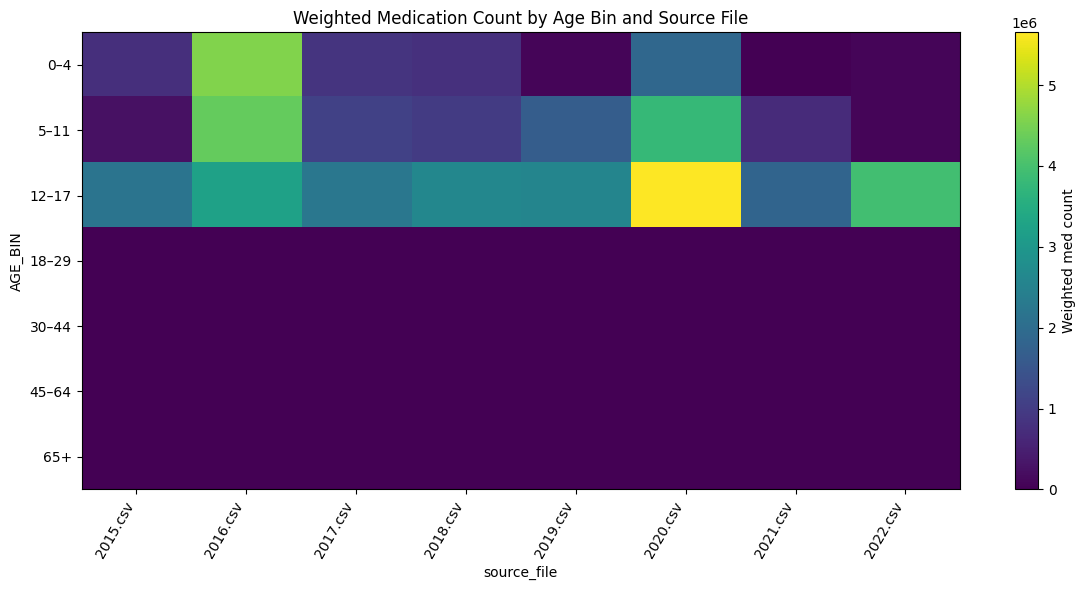

NameError: name 'order' is not defined

In [ ]:
def prepare_weighted_meds_long(df: pd.DataFrame,
                               use_gpmed: bool = True,
                               age_bins = None,
                               age_labels = None):
    """
    Reshapes wide MED*/GPMED* columns into a long table with one row per medication
    per visit, carrying the visit's PATWT as the weight for that medication.
    """
    df = df.copy()

    if use_gpmed:
        med_cols = [c for c in df.columns if re.fullmatch(r"GPMED\d+", c)]
        med_colname = "GPMED_code"
    else:
        med_cols = [c for c in df.columns if re.fullmatch(r"MED\d+", c)]
        med_colname = "MED_code"

    keep_cols = ["source_file", "AGE", "PATWT"]
    keep_cols = [c for c in keep_cols if c in df.columns]

    long = df.melt(id_vars=keep_cols,
                   value_vars=med_cols,
                   var_name="med_slot",
                   value_name=med_colname)


    long[med_colname] = long[med_colname].replace(["", " ", "0", 0], np.nan)
    long = long.dropna(subset=[med_colname])

    #  age binning
    if age_bins is None:
        age_bins = [0, 5, 12, 18, 30, 45, 65, 120]
        age_labels = ["0–4", "5–11", "12–17", "18–29", "30–44", "45–64", "65+"]

    long["AGE_BIN"] = pd.cut(long["AGE"], bins=age_bins, labels=age_labels, right=False)

    long["WEIGHT"] = long["PATWT"]

    return long, med_colname


meds_long, med_col = prepare_weighted_meds_long(peds_df, use_gpmed=True)


by_source = (meds_long
             .groupby("source_file", as_index=False)["WEIGHT"]
             .sum()
             .rename(columns={"WEIGHT": "weighted_med_count"}))


by_source_age = (meds_long
                 .groupby(["source_file", "AGE_BIN"], as_index=False)["WEIGHT"]
                 .sum()
                 .rename(columns={"WEIGHT": "weighted_med_count"}))


by_source_age_type = (meds_long
                      .groupby(["source_file", "AGE_BIN", med_col], as_index=False)["WEIGHT"]
                      .sum()
                      .rename(columns={"WEIGHT": "weighted_med_count"}))

topN = 15
top_codes = (by_source_age_type.groupby(med_col)["weighted_med_count"]
             .sum()
             .sort_values(ascending=False)
             .head(topN)
             .index)
by_source_age_type_top = by_source_age_type[by_source_age_type[med_col].isin(top_codes)]

# --- 3) Plots (matplotlib only) ---
pivot_age_source = by_source_age.pivot(index="AGE_BIN", columns="source_file", values="weighted_med_count").fillna(0)

plt.figure(figsize=(12, 6))
plt.imshow(pivot_age_source.values, aspect="auto")
plt.title("Weighted Medication Count by Age Bin and Source File")
plt.xlabel("source_file")
plt.ylabel("AGE_BIN")
plt.yticks(ticks=range(len(pivot_age_source.index)), labels=pivot_age_source.index)
plt.xticks(ticks=range(len(pivot_age_source.columns)), labels=pivot_age_source.columns, rotation=60, ha="right")
plt.colorbar(label="Weighted med count")
plt.tight_layout()
plt.show()


stack_src_med = (by_source_age_type_top
                 .groupby(["source_file", med_col], as_index=False)["weighted_med_count"]
                 .sum())


wide = (stack_src_med
        .pivot(index="source_file", columns=med_col, values="weighted_med_count")
        .fillna(0)
        .loc[order["source_file"]]) 

plt.figure(figsize=(12, 6))
bottom = np.zeros(len(wide))
x = np.arange(len(wide.index))
for code in wide.columns:
    plt.bar(x, wide[code].values, bottom=bottom, label=str(code))
    bottom += wide[code].values

plt.title(f"Weighted Medication Count by Source File (Top {topN} {med_col} codes)")
plt.xlabel("source_file")
plt.ylabel("Weighted med count")
plt.xticks(x, wide.index, rotation=60, ha="right")
plt.legend(title=med_col, bbox_to_anchor=(1.02, 1), loc="upper left", ncol=1)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.tight_layout()
plt.show()


In [ ]:

# catch common placeholders + saline/contrast variants
STOP_TERMS_RE = re.compile(
    r"""
    (?xi)                                   # ignore case, verbose
    ^\s*(?:                                  # whole string after trim
        # explicit empties / unknowns
        no\s*entry\s*made|
        none|
        n/?a|
        unknown|
        not\s*applicable|
        illegible(?:\s*[- ]?\d+)?|

        # Saline / NaCl / Sodium Chloride (any concentration or form)
        (?:normal\s*)?saline(?:\s*flush)?(?:\b.*)?|
        ns\b(?:\b.*)?|
        (?:na?cl|sodium\s*chloride)(?:\b.*)?|

        # Contrast agents
        omnipaque(?:\s*[- ]?\d+)?(?:\b.*)?|
        isovue(?:\s*[- ]?\d+)?(?:\b.*)?|
        iohexol(?:\s*[- ]?\d+)?(?:\b.*)?|
        iopamidol(?:\s*[- ]?\d+)?(?:\b.*)?|

        # Zofran
        zofran(?:\s*[- ]?\d+)?(?:\b.*)?
    )\s*$
    """,
)

def meds_long_from_MED(df: pd.DataFrame, weight_col="PATWT", dedupe_per_visit=True):
    d = df.copy()
    med_cols = [c for c in d.columns if re.fullmatch(r"MED\d+", c)]
    if not med_cols:
        raise ValueError("No MED* columns found.")

    d = d.reset_index().rename(columns={"index": "visit_id"})
    id_vars = ["visit_id", "source_file", weight_col] + (["ADMIT"] if "ADMIT" in d.columns else [])

    long = d.melt(id_vars=id_vars, value_vars=med_cols,
                  var_name="slot", value_name="MED_NAME")

    # normalizee
    long["MED_NAME"] = long["MED_NAME"].astype(str).str.strip()

    # remove blanks/zeros/stop terms (case-insensitive)
    long = long[~long["MED_NAME"].isin(["", "0"])]
    long = long[~long["MED_NAME"].str.match(STOP_TERMS_RE, na=False)]

    # tidy capitalization *after* filtering
    long["MED_NAME"] = (long["MED_NAME"]
                        .str.replace(r"\s+", " ", regex=True)
                        .str.title())

    # YEAR from source_file, fallback to ADMIT
    year_from_file = long["source_file"].astype(str).str.extract(r'((19|20)\d{2})')[0]
    if "ADMIT" in long.columns:
        year_from_admit = long["ADMIT"].astype(str).str.extract(r'((19|20)\d{2})')[0]
        long["YEAR"] = year_from_file.fillna(year_from_admit)
    else:
        long["YEAR"] = year_from_file
    long = long.dropna(subset=["YEAR"]).assign(YEAR=lambda x: x["YEAR"].astype(str))

    # weights
    long["WEIGHT"] = pd.to_numeric(long[weight_col], errors="coerce")
    long = long.dropna(subset=["WEIGHT"])

    if dedupe_per_visit:
        long = long.drop_duplicates(subset=["visit_id", "YEAR", "MED_NAME"])

    return long

NameError: name 'ax' is not defined

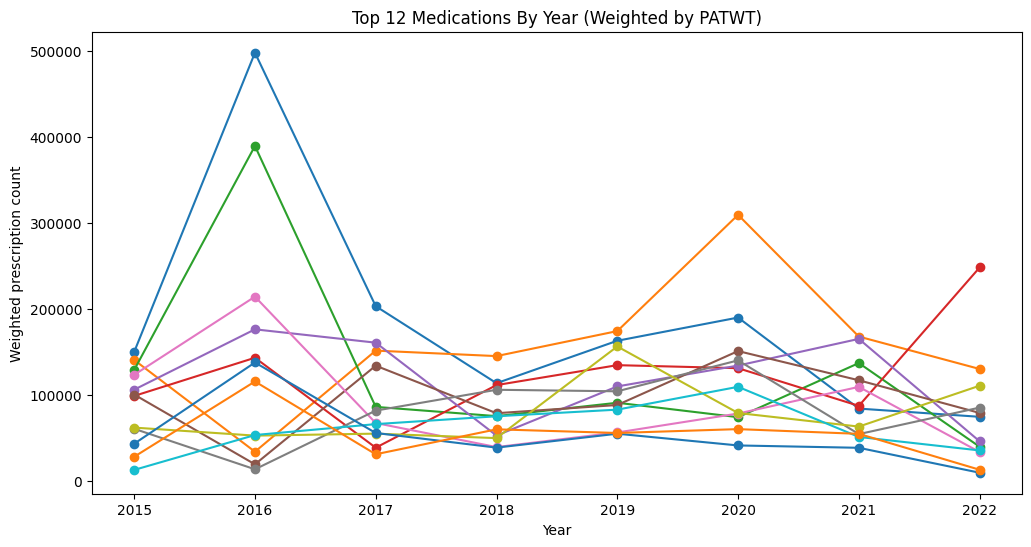

In [ ]:
# Build long table (use  combined df like peds_df or combined_df)
meds_long = meds_long_from_MED(adults_df, weight_col="PATWT", dedupe_per_visit=True)

# Aggregate by YEAR × MED_NAME (weighted)
by_year_med = (meds_long
               .groupby(["YEAR", "MED_NAME"], as_index=False)["WEIGHT"]
               .sum()
               .rename(columns={"WEIGHT": "weighted_count"}))

# Top N meds overall 
topN = 12
top_meds = (by_year_med.groupby("MED_NAME")["weighted_count"]
            .sum()
            .sort_values(ascending=False)
            .head(topN)
            .index)

plot_data = by_year_med[by_year_med["MED_NAME"].isin(top_meds)].copy()

plt.figure(figsize=(12, 6))
for med in top_meds:
    s = plot_data[plot_data["MED_NAME"] == med].sort_values("YEAR")
    plt.plot(s["YEAR"], s["weighted_count"], marker="o", label=med)

plt.title(f"Top {topN} Medications By Year (Weighted by PATWT)")
plt.xlabel("Year")
plt.ylabel("Weighted prescription count")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.legend(title="Medication", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Stacked bars per year
pivot = (plot_data
         .pivot(index="YEAR", columns="MED_NAME", values="weighted_count")
         .reindex(columns=list(top_meds), fill_value=0)
         .apply(pd.to_numeric, errors="coerce")
         .fillna(0)
         .sort_index(key=lambda s: s.astype(int)))

ax = pivot.plot(kind="bar", stacked=True, figsize=(12, 7))
ax.set_title(f"Top {len(top_meds)} Medications Per Year (Stacked, Weighted)")
ax.set_xlabel("Year")
ax.set_ylabel("Weighted prescription count")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.legend(title="Medication", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


NameError: name 'ax' is not defined

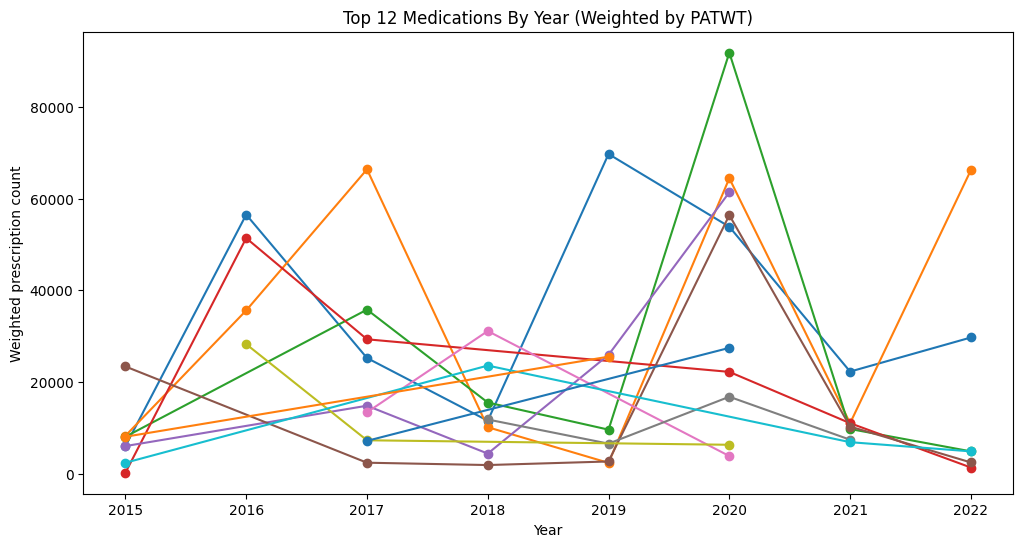

In [ ]:
import matplotlib.ticker as mtick

meds_long = meds_long_from_MED(peds_df, weight_col="PATWT", dedupe_per_visit=True)

by_year_med = (meds_long
               .groupby(["YEAR", "MED_NAME"], as_index=False)["WEIGHT"]
               .sum()
               .rename(columns={"WEIGHT": "weighted_count"}))

# Top N meds overall 
topN = 12
top_meds = (by_year_med.groupby("MED_NAME")["weighted_count"]
            .sum()
            .sort_values(ascending=False)
            .head(topN)
            .index)

plot_data = by_year_med[by_year_med["MED_NAME"].isin(top_meds)].copy()

plt.figure(figsize=(12, 6))
for med in top_meds:
    s = plot_data[plot_data["MED_NAME"] == med].sort_values("YEAR")
    plt.plot(s["YEAR"], s["weighted_count"], marker="o", label=med)

plt.title(f"Top {topN} Medications By Year (Weighted by PATWT)")
plt.xlabel("Year")
plt.ylabel("Weighted prescription count")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.legend(title="Medication", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

pivot = (plot_data
         .pivot(index="YEAR", columns="MED_NAME", values="weighted_count")
         .reindex(columns=list(top_meds), fill_value=0)
         .apply(pd.to_numeric, errors="coerce")
         .fillna(0)
         .sort_index(key=lambda s: s.astype(int)))

ax = pivot.plot(kind="bar", stacked=True, figsize=(12, 7))
ax.set_title(f"Top {len(top_meds)} Medications Per Year (Stacked, Weighted)")
ax.set_xlabel("Year")
ax.set_ylabel("Weighted prescription count")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.legend(title="Medication", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


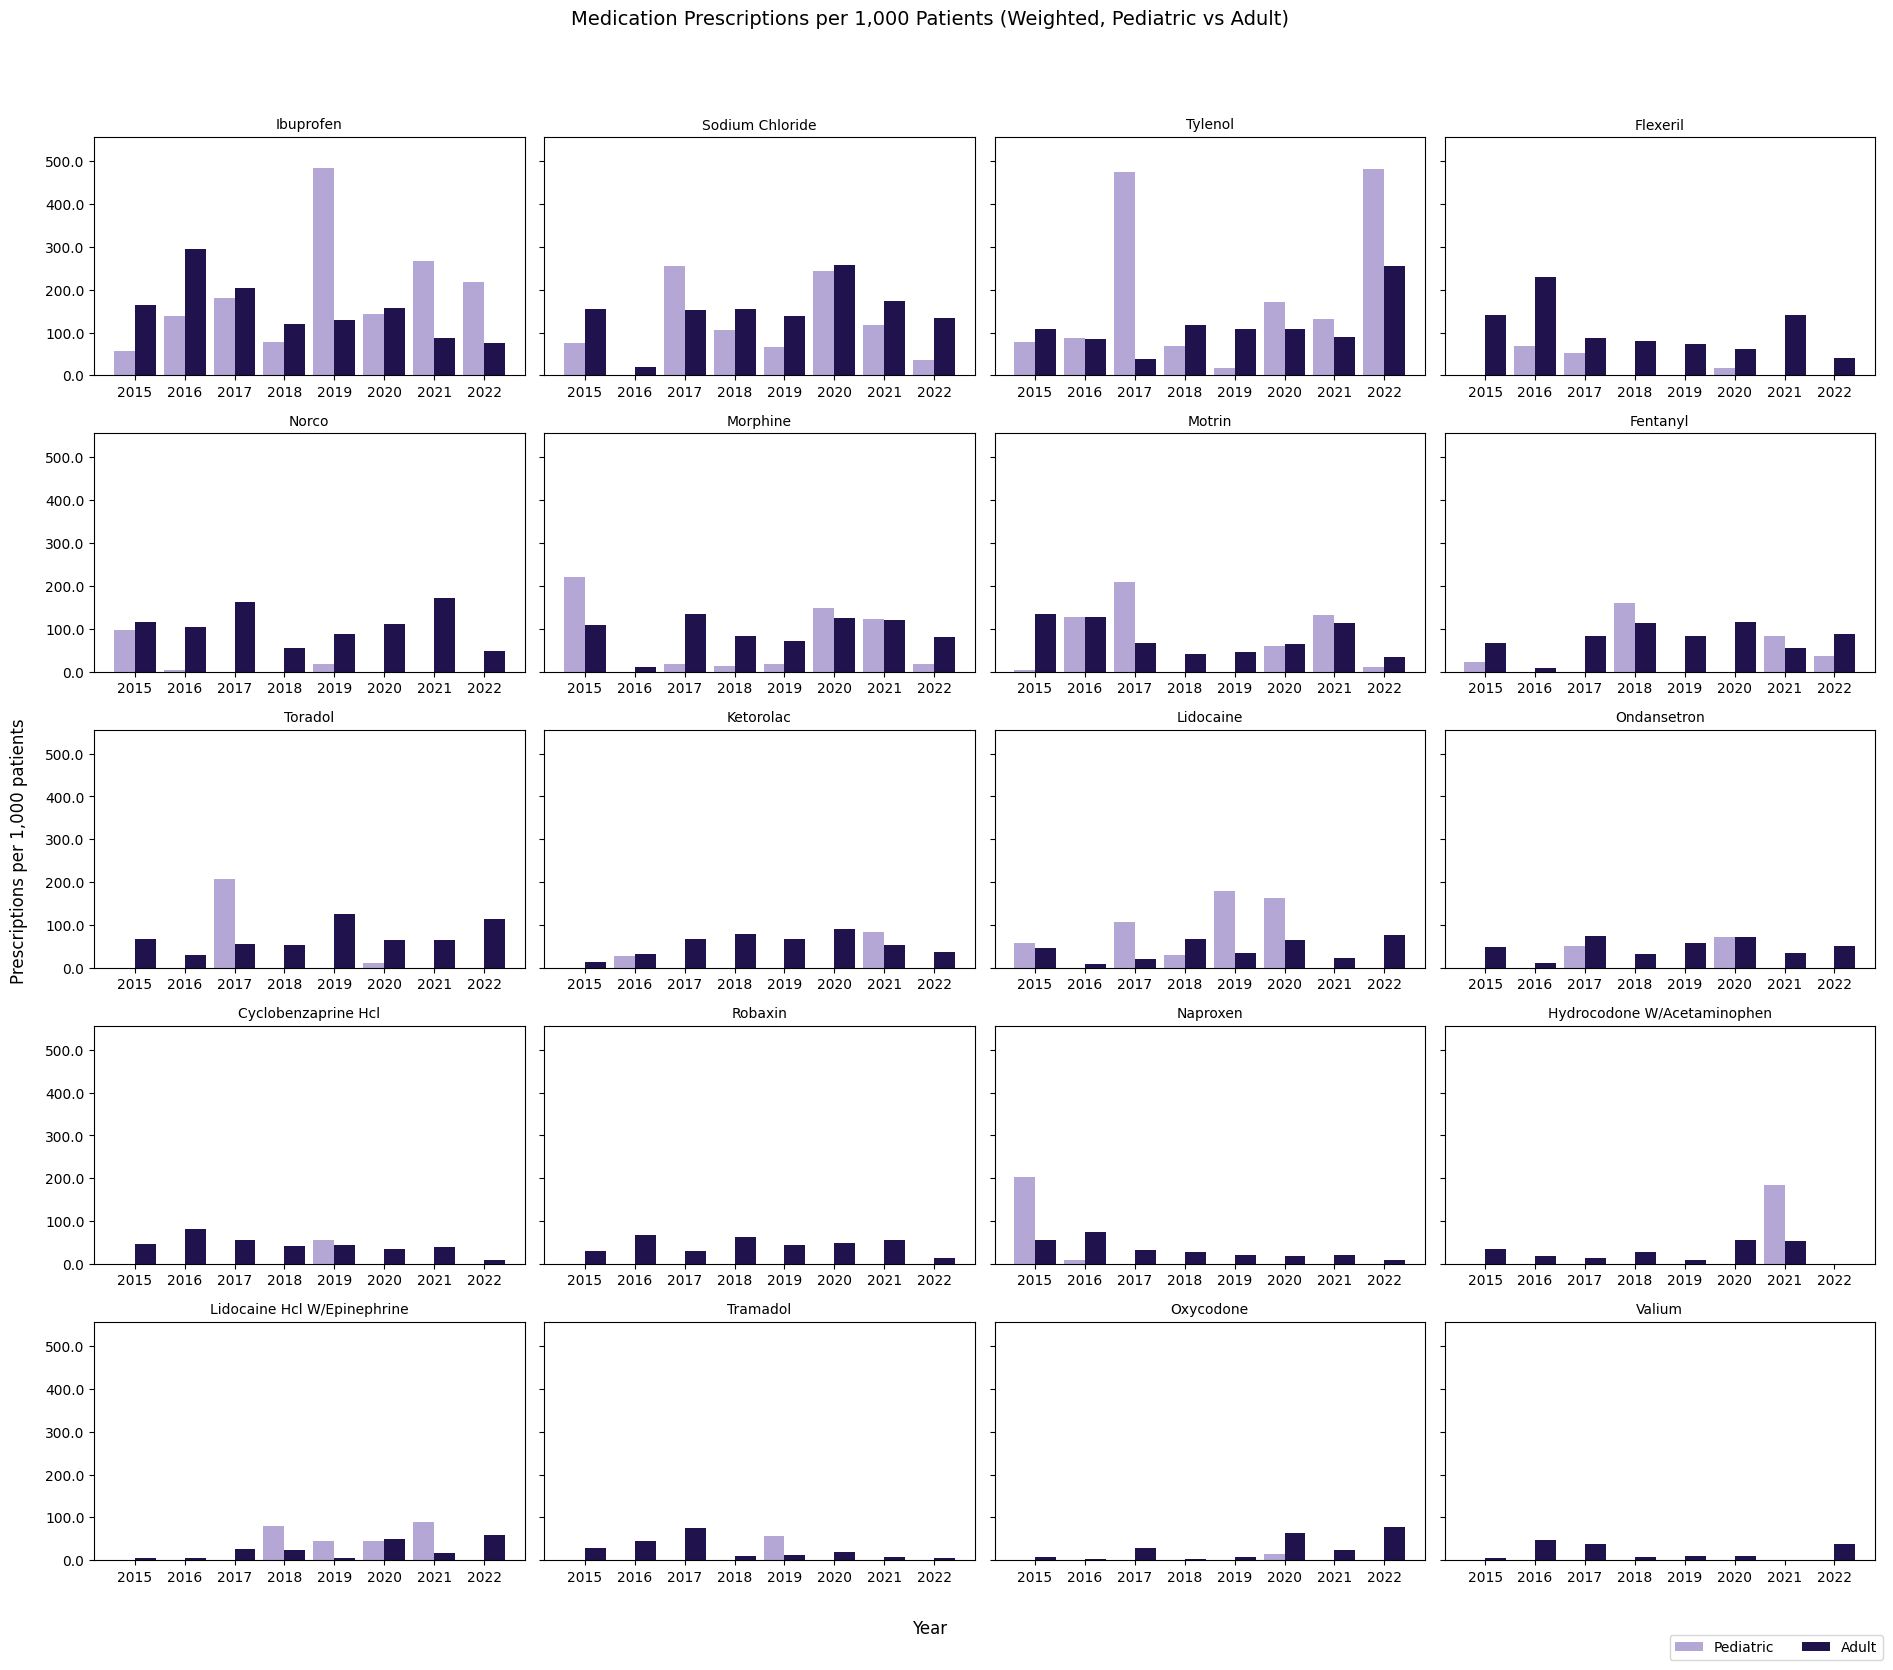

Saved panel: meds_peds_vs_adults_panel.png


In [ ]:
import matplotlib.ticker as mtick


# ---------- helper: denominators (weighted patients/visits per year) ----------
def denom_by_year(df: pd.DataFrame, weight_col="PATWT"):
    x = df.copy()
    yr_file = x["source_file"].astype(str).str.extract(r'((19|20)\d{2})')[0]
    if "ADMIT" in x.columns:
        yr_admit = x["ADMIT"].astype(str).str.extract(r'((19|20)\d{2})')[0]
        x["YEAR"] = yr_file.fillna(yr_admit)
    else:
        x["YEAR"] = yr_file
    x = x.dropna(subset=["YEAR"]).assign(YEAR=lambda d: d["YEAR"].astype(str))
    x["WEIGHT"] = pd.to_numeric(x[weight_col], errors="coerce")
    x = x.dropna(subset=["WEIGHT"])
    return x.groupby("YEAR", as_index=False)["WEIGHT"].sum().rename(columns={"WEIGHT":"denom_weight"})

# ---------- build numerators (med counts) & denominators ----------
peds_long   = meds_long_from_MED(peds_df,   weight_col="PATWT", dedupe_per_visit=True)
adults_long = meds_long_from_MED(adults_df, weight_col="PATWT", dedupe_per_visit=True)

peds_num   = (peds_long.groupby(["YEAR","MED_NAME"], as_index=False)["WEIGHT"].sum()
              .rename(columns={"WEIGHT":"weighted_count"}))
adults_num = (adults_long.groupby(["YEAR","MED_NAME"], as_index=False)["WEIGHT"].sum()
              .rename(columns={"WEIGHT":"weighted_count"}))

peds_den   = denom_by_year(peds_df,   weight_col="PATWT")  
adults_den = denom_by_year(adults_df, weight_col="PATWT")

peds_num["Group"]   = "Pediatric"
adults_num["Group"] = "Adult"

# ---------- normalize to rates per 1,000 patients ----------
RATE_SCALE = 1000.0   # change to 100000.0 for per 100k

peds = peds_num.merge(peds_den, on="YEAR", how="left")
peds["rate_per_k"] = (peds["weighted_count"] / peds["denom_weight"]) * RATE_SCALE

adults = adults_num.merge(adults_den, on="YEAR", how="left")
adults["rate_per_k"] = (adults["weighted_count"] / adults["denom_weight"]) * RATE_SCALE

both = pd.concat([peds, adults], ignore_index=True)

# ---------- choose drugs to show (topN by total weighted_count across both groups) ----------
topN = 20
top_meds = (both.groupby("MED_NAME")["weighted_count"].sum()
            .sort_values(ascending=False).head(topN).index.tolist())

plot_df = both[both["MED_NAME"].isin(top_meds)].copy()
years_all = sorted(plot_df["YEAR"].unique(), key=lambda y: int(y))

# ---------- big panel: one subplot per drug, bars = Peds vs Adult for each year ----------
n = len(top_meds)
ncols = 4
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols + 4, 3*nrows + 2), sharey=True)
axes = np.array(axes).reshape(nrows, ncols)

# find a common y-limit (max rate across all panels)
def panel_max(drug):
    sub = plot_df[plot_df["MED_NAME"] == drug]
    piv = (sub.pivot_table(index="YEAR", columns="Group", values="rate_per_k", aggfunc="sum")
           .reindex(index=years_all).fillna(0))
    return float(piv.max().max())

ymax = max(panel_max(d) for d in top_meds) * 1.15

for i, drug in enumerate(top_meds):
    r, c = divmod(i, ncols)
    ax = axes[r, c]

    sub = plot_df[plot_df["MED_NAME"] == drug]
    piv = (sub.pivot_table(index="YEAR", columns="Group", values="rate_per_k", aggfunc="sum")
           .reindex(index=years_all).fillna(0))
    # ensure both columns exist
    for col in ["Pediatric","Adult"]:
        if col not in piv.columns: piv[col] = 0.0

    idx = np.arange(len(piv.index)); width = 0.42
    ax.bar(idx - width/2, piv["Pediatric"].values, width, label="Pediatric", color='#b4a7d6')
    ax.bar(idx + width/2, piv["Adult"].values,     width, label="Adult", color = '#20134d')

    ax.set_title(drug, fontsize=10)
    ax.set_xticks(idx)
    ax.set_xticklabels(piv.index, rotation=0)
    ax.set_ylim(0, ymax)

    # pretty y-axis: rates per 1k
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:,.1f}"))

for j in range(n, nrows*ncols):
    r, c = divmod(j, ncols)
    fig.delaxes(axes[r, c])

fig.suptitle(f"Medication Prescriptions per {int(RATE_SCALE):,} Patients (Weighted, Pediatric vs Adult)", fontsize=14, y=0.995)
fig.text(0.5, 0.04, "Year", ha="center", fontsize=12)
fig.text(0.04, 0.5, f"Prescriptions per {int(RATE_SCALE):,} patients", va="center", rotation="vertical", fontsize=12)

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, bbox_to_anchor=(0.98, 0.02), loc="lower right")

plt.tight_layout(rect=[0.05, 0.06, 0.98, 0.96])
plt.savefig("meds_peds_vs_adults_panel.png", dpi=200)
plt.show()
print("Saved panel: meds_peds_vs_adults_panel.png")


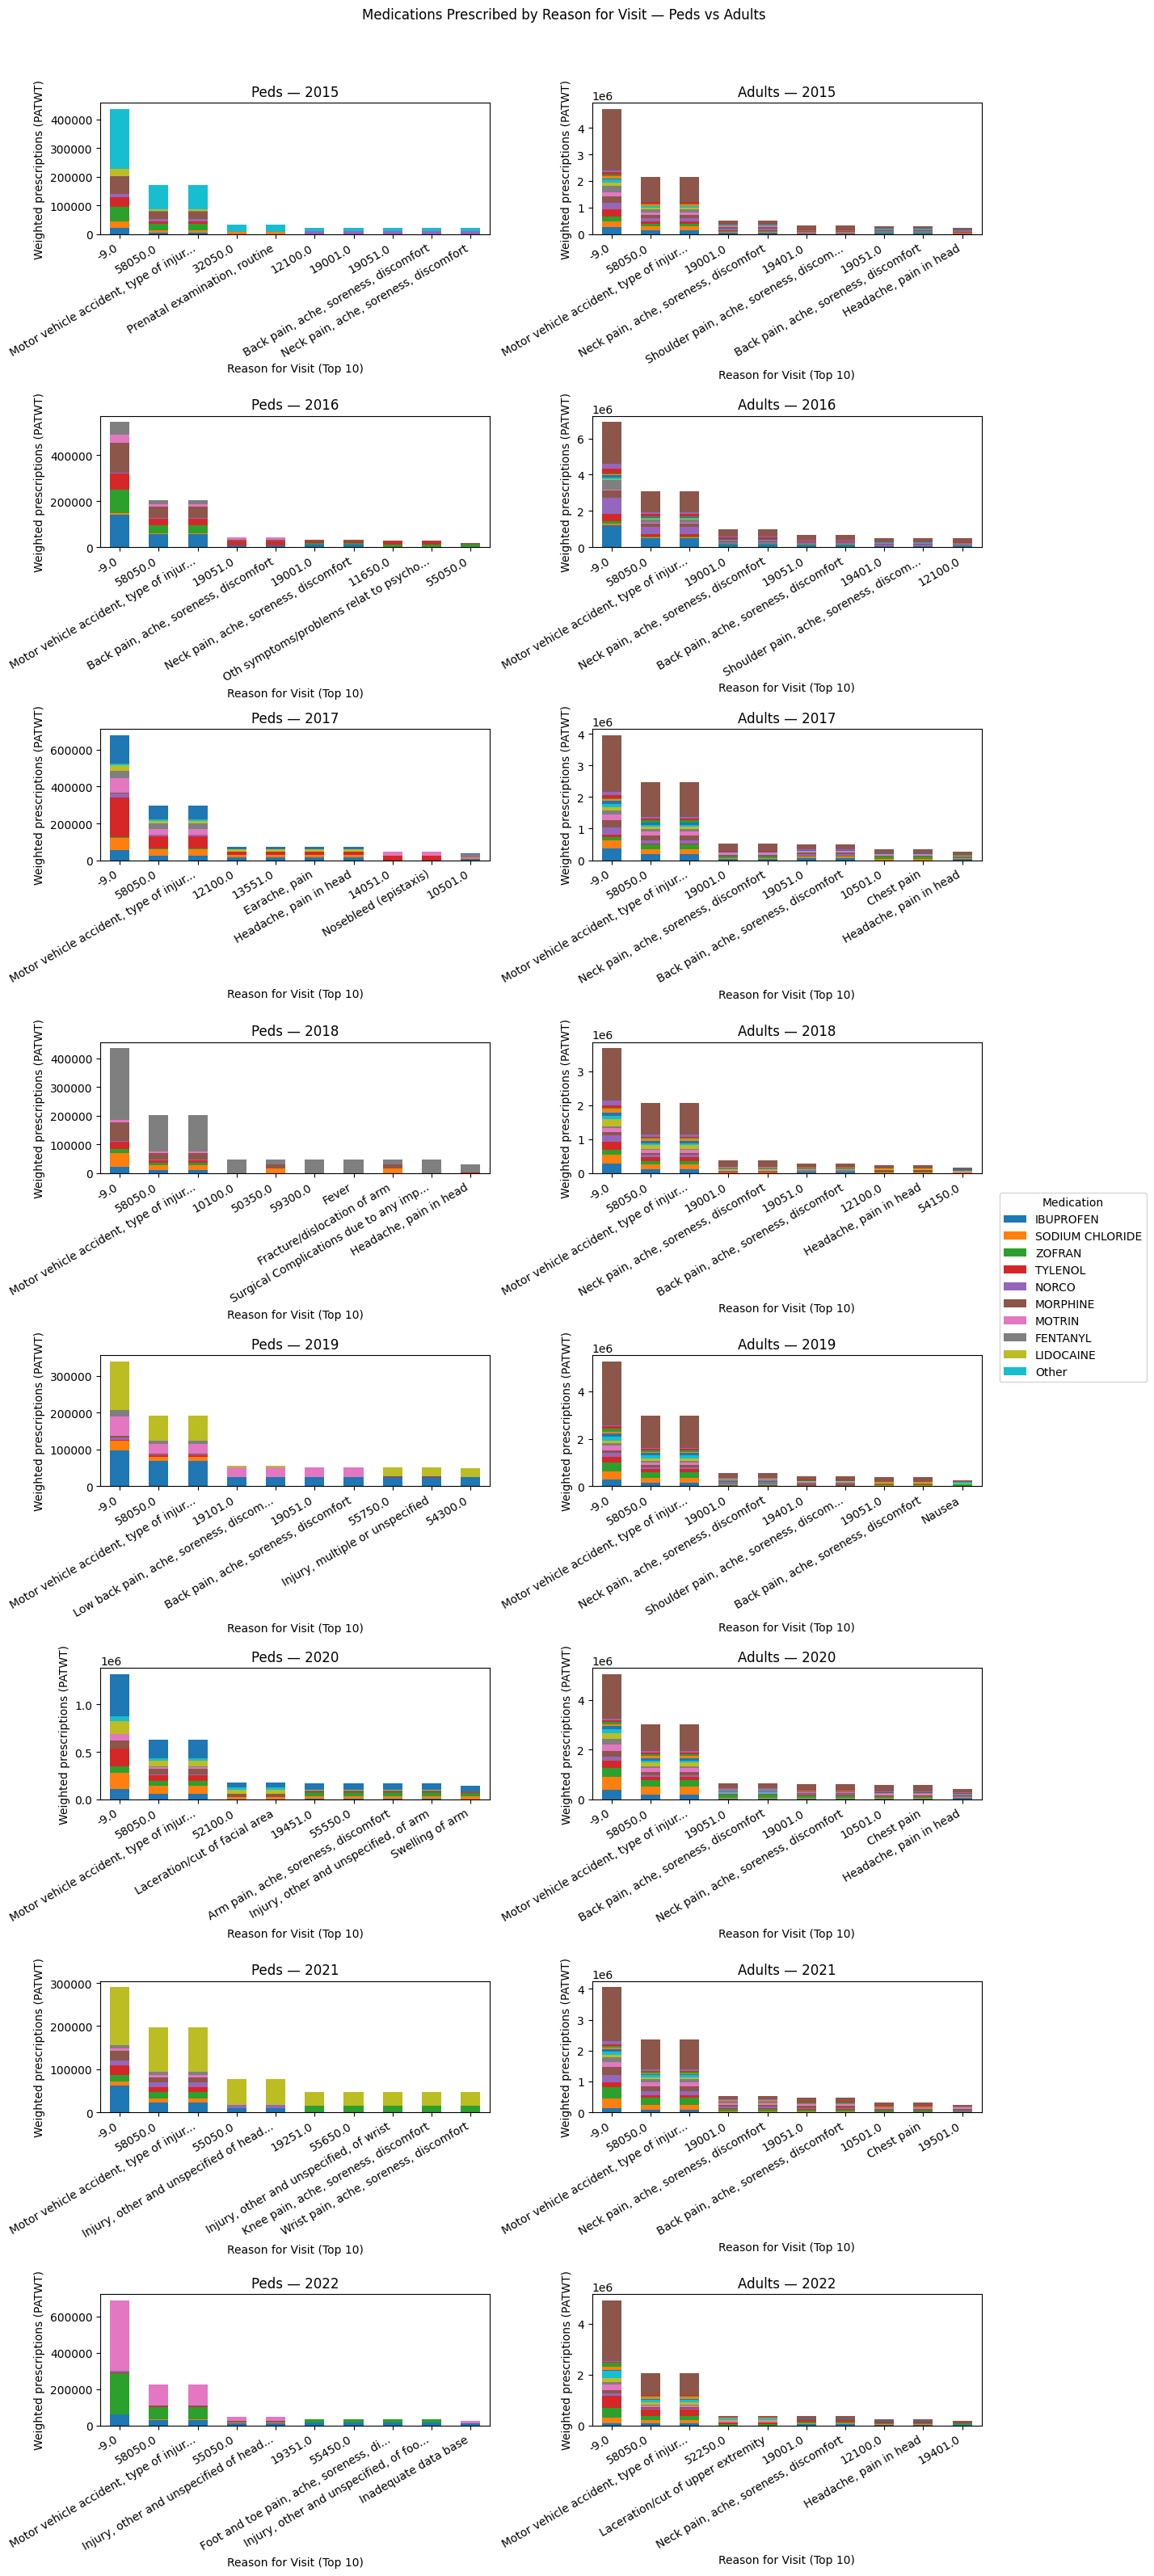

In [ ]:
from math import ceil

def plot_stacked_by_rfv_and_med_vertical(
    peds: pd.DataFrame,
    adults: pd.DataFrame,
    rfv_prefix="RFV",
    med_prefix="Med",
    weight_col="PATWT",
    source_col="source_file",
    top_k_meds=15,
    top_k_rfvs=10,
):
    # add cohort labels
    p = peds.copy(); p["COHORT"] = "Peds"
    a = adults.copy(); a["COHORT"] = "Adults"
    df = pd.concat([p, a], ignore_index=True)

    # YEAR
    df["YEAR"] = df[source_col].astype(str).str.extract(r'((19|20)\d{2})')[0]
    df = df.dropna(subset=["YEAR"])
    df["YEAR"] = df["YEAR"].astype(int)

    # find columns
    rfv_cols = [c for c in df.columns if c.upper().startswith(rfv_prefix.upper())]
    med_cols = [c for c in df.columns if c.upper().startswith(med_prefix.upper())]

    df[weight_col] = pd.to_numeric(df[weight_col], errors="coerce")
    df = df.dropna(subset=[weight_col]).reset_index(drop=False).rename(columns={"index": "_ROWID"})

    # melt RFVs
    rfv_long = (
        df[["_ROWID", "YEAR", "COHORT", weight_col] + rfv_cols]
        .melt(id_vars=["_ROWID", "YEAR", "COHORT", weight_col],
              value_vars=rfv_cols,
              var_name="RFV_COL", value_name="RFV")
        .dropna(subset=["RFV"])
    )
    rfv_long["RFV"] = rfv_long["RFV"].astype(str).str.strip()
    bad_rfvs = {"-9", "BLANK", ""}
    rfv_long = rfv_long[~rfv_long["RFV"].str.upper().isin(bad_rfvs)]

    # melt MEDs
    med_long = (
        df[["_ROWID", "YEAR", "COHORT"] + med_cols]
        .melt(id_vars=["_ROWID", "YEAR", "COHORT"],
              value_vars=med_cols,
              var_name="MED_COL", value_name="MED")
        .dropna(subset=["MED"])
    )
    med_long["MED"] = med_long["MED"].astype(str).str.strip()
    med_long = med_long[~med_long["MED"].str.upper().isin(["NO ENTRY MADE", ""])]

    # cross-join
    pairs = rfv_long.merge(
        med_long[["_ROWID", "YEAR", "COHORT", "MED"]],
        on=["_ROWID", "YEAR", "COHORT"],
        how="inner",
    )

    # aggregate
    agg = (
        pairs.groupby(["YEAR", "COHORT", "RFV", "MED"], as_index=False)[weight_col]
            .sum()
            .rename(columns={weight_col: "weighted_count"})
    )

    years = sorted(agg["YEAR"].unique())
    cohorts = ["Peds", "Adults"]

    # global top meds
    keep_meds = (
        agg.groupby("MED")["weighted_count"]
        .sum().sort_values(ascending=False)
        .head(top_k_meds).index.tolist()
    )

    # fig: years stacked vertically, 2 cols (Peds/Adults)
    nrows = len(years)
    fig, axes = plt.subplots(
        nrows=nrows, ncols=len(cohorts),
        figsize=(14, 4 * nrows), squeeze=False
    )

    shared_handles, shared_labels = None, None

    for r, yr in enumerate(years):
        for c, cohort in enumerate(cohorts):
            ax = axes[r, c]
            sub = agg[(agg["YEAR"] == yr) & (agg["COHORT"] == cohort)].copy()
            if sub.empty:
                ax.axis("off")
                ax.set_title(f"{cohort} — {yr}\n(No data)")
                continue

            sub["MED_plot"] = sub["MED"].where(sub["MED"].isin(keep_meds), "Other")

            top_rfvs = (
                sub.groupby("RFV")["weighted_count"].sum()
                   .sort_values(ascending=False).head(top_k_rfvs).index.tolist()
            )
            sub = sub[sub["RFV"].isin(top_rfvs)]

            panel = sub.groupby(["RFV", "MED_plot"], as_index=False)["weighted_count"].sum()
            pivot = panel.pivot(index="RFV", columns="MED_plot", values="weighted_count").fillna(0)

            # consistent column order
            col_order = [m for m in keep_meds if m in pivot.columns]
            if "Other" in pivot.columns: col_order.append("Other")
            pivot = pivot[col_order]

            pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]

            pivot.plot(kind="bar", stacked=True, ax=ax, legend=False)
            ax.set_title(f"{cohort} — {yr}")
            ax.set_xlabel("Reason for Visit (Top 10)")
            ax.set_ylabel("Weighted prescriptions (PATWT)")
            for lbl in ax.get_xticklabels():
                lbl.set_rotation(30)
                lbl.set_horizontalalignment("right")

            if shared_handles is None:
                handles, labels = ax.get_legend_handles_labels()
                shared_handles, shared_labels = handles, labels

    if shared_handles:
        fig.legend(shared_handles, shared_labels, title="Medication",
                   loc="center right", bbox_to_anchor=(1.02, 0.5))
    fig.suptitle("Medications Prescribed by Reason for Visit — Peds vs Adults", y=0.995)
    plt.tight_layout(rect=[0, 0, 0.88, 0.98])
    plt.show()

   
plot_stacked_by_rfv_and_med_vertical(peds_df, adults_df)


In [ ]:
def plot_med_trends_year_stacked_if_overlap(
    peds: pd.DataFrame,
    adults: pd.DataFrame,
    top_k_meds: int = 10,
    rfv_prefix="RFV",
    med_prefix="Med",
    weight_col="PATWT",
    source_col="source_file",
    stop_terms_re=None,   
):
    agg = _build_med_year_agg(peds, adults, rfv_prefix, med_prefix, weight_col, source_col)
    if stop_terms_re is not None:
        agg = agg[~agg["MED"].str.match(stop_terms_re, na=False)]
    if agg.empty:
        print("No data to plot after cleaning.")
        return

    years = sorted(agg["YEAR"].unique())
    year_index = pd.Index(years, name="YEAR")

    top_peds = (agg[agg["COHORT"]=="Peds"]
                .groupby("MED")["weighted_count"].sum()
                .sort_values(ascending=False).head(top_k_meds).index.tolist())
    top_adults = (agg[agg["COHORT"]=="Adults"]
                .groupby("MED")["weighted_count"].sum()
                .sort_values(ascending=False).head(top_k_meds).index.tolist())

    meds_union = list(dict.fromkeys(top_peds + top_adults))  

    ncols = 5
    nrows = -(-len(meds_union) // ncols)  
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows), squeeze=False)

    for i, med in enumerate(meds_union):
        r, c = divmod(i, ncols)
        ax = axes[r, c]

        sub = agg[agg["MED"]==med]

        # Pivot into YEAR × COHORT table
        pivot = (sub.groupby(["YEAR","COHORT"])["weighted_count"].sum().unstack(fill_value=0)
                 .reindex(year_index, fill_value=0))

        if "Peds" in pivot.columns and "Adults" in pivot.columns:
            ax.bar(pivot.index.astype(str), pivot["Peds"], label="Peds", color = "#b4a7d6")
            ax.bar(pivot.index.astype(str), pivot["Adults"], bottom=pivot["Peds"], label="Adults", color = '#20134d')

        else:
            for cohort in pivot.columns:
                ax.bar(pivot.index.astype(str), pivot[cohort], label=cohort)

        ax.set_title(med)
        ax.set_xlabel("Year")
        ax.set_ylabel("Weighted prescriptions")
        for lbl in ax.get_xticklabels():
            lbl.set_rotation(45)
            lbl.set_horizontalalignment("right")

    # hide any unused axes
    for j in range(i+1, nrows*ncols):
        r, c = divmod(j, ncols)
        axes[r,c].axis("off")

    handles, labels = axes[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, title="Cohort", loc="upper right")
    fig.suptitle(f"Top {top_k_meds} Medications (per cohort) — Stacked if overlap", y=0.995)
    plt.tight_layout(rect=[0,0,0.9,0.97])
    plt.show()



In [ ]:
def plot_med_rfv_breakdown(
    peds: pd.DataFrame,
    adults: pd.DataFrame,
    med_prefix="Med",
    rfv_prefix="RFV",
    weight_col="PATWT",
    source_col="source_file",
    top_k_meds=6,
    top_k_rfvs=8
):
    # combine + cohort labels
    p = peds.copy(); p["COHORT"] = "Peds"
    a = adults.copy(); a["COHORT"] = "Adults"
    df = pd.concat([p, a], ignore_index=True)

    df["YEAR"] = df[source_col].astype(str).str.extract(r'((19|20)\d{2})')[0]
    df = df.dropna(subset=["YEAR"])
    df["YEAR"] = df["YEAR"].astype(int)

    # discover columns
    rfv_cols = [c for c in df.columns if c.upper().startswith(rfv_prefix.upper())]
    med_cols = [c for c in df.columns if c.upper().startswith(med_prefix.upper())]
    if not rfv_cols:
        raise KeyError(f"No RFV* columns with prefix '{rfv_prefix}'.")
    if not med_cols:
        raise KeyError(f"No Med* columns with prefix '{med_prefix}'.")

    # weights + row id
    df[weight_col] = pd.to_numeric(df[weight_col], errors="coerce")
    df = df.dropna(subset=[weight_col])
    if "_ROWID" not in df.columns:
        df = df.reset_index(drop=False).rename(columns={"index": "_ROWID"})

    # RFVs long + clean
    rfv_long = (
        df[["_ROWID","YEAR","COHORT",weight_col] + rfv_cols]
        .melt(id_vars=["_ROWID","YEAR","COHORT",weight_col],
              value_vars=rfv_cols,
              var_name="RFV_COL", value_name="RFV")
        .dropna(subset=["RFV"])
    )
    rfv_long["RFV"] = rfv_long["RFV"].astype(str).str.strip()
    rfv_long = rfv_long[~rfv_long["RFV"].str.upper().isin({"-9","BLANK",""})]
    rfv_long = rfv_long[rfv_long["RFV"] != ""]
    rfv_long = rfv_long[~rfv_long["RFV"].str.match(r"^-?\d+(\.\d+)?$")]

    # Meds long + clean (apply STOP_TERMS_RE)
    med_long = (
        df[["_ROWID","YEAR","COHORT"] + med_cols]
        .melt(id_vars=["_ROWID","YEAR","COHORT"],
              value_vars=med_cols,
              var_name="MED_COL", value_name="MED")
        .dropna(subset=["MED"])
    )
    med_long["MED"] = med_long["MED"].astype(str).str.strip()
    med_long = med_long[med_long["MED"] != ""]
    med_long = med_long[~med_long["MED"].str.match(STOP_TERMS_RE, na=False)]

    # cross-join and aggregate
    pairs = rfv_long.merge(med_long, on=["_ROWID","YEAR","COHORT"], how="inner")
    agg = (pairs.groupby(["MED","RFV","COHORT"], as_index=False)[weight_col]
                .sum().rename(columns={weight_col:"weighted_count"}))

    if agg.empty:
        print("No data to plot after filtering.")
        return

    # pick top meds overall (by total across RFVs/cohorts)
    top_meds = (agg.groupby("MED")["weighted_count"].sum()
                  .sort_values(ascending=False).head(top_k_meds).index.tolist())
    agg = agg[agg["MED"].isin(top_meds)]

    # plot
    ncols = 2
    nrows = -(-len(top_meds)//ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(10*ncols, 4*nrows), squeeze=False)

    for i, med in enumerate(top_meds):
        r, c = divmod(i, ncols)
        ax = axes[r, c]
        sub = agg[agg["MED"]==med]

        # top RFVs for this med
        top_rfvs = (sub.groupby("RFV")["weighted_count"].sum()
                      .sort_values(ascending=False).head(top_k_rfvs).index.tolist())
        sub = sub[sub["RFV"].isin(top_rfvs)]

        pivot = sub.pivot(index="RFV", columns="COHORT", values="weighted_count").fillna(0)
        pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]

        pivot.plot(kind="barh", stacked=True, ax=ax)
        ax.set_title(f"{med}: Top RFVs")
        ax.set_xlabel("Weighted prescriptions"); ax.set_ylabel("Reason for Visit")

    # hide unused axes
    for j in range(i+1, nrows*ncols):
        r, c = divmod(j, ncols)
        axes[r, c].axis("off")

    plt.tight_layout()
    plt.show()


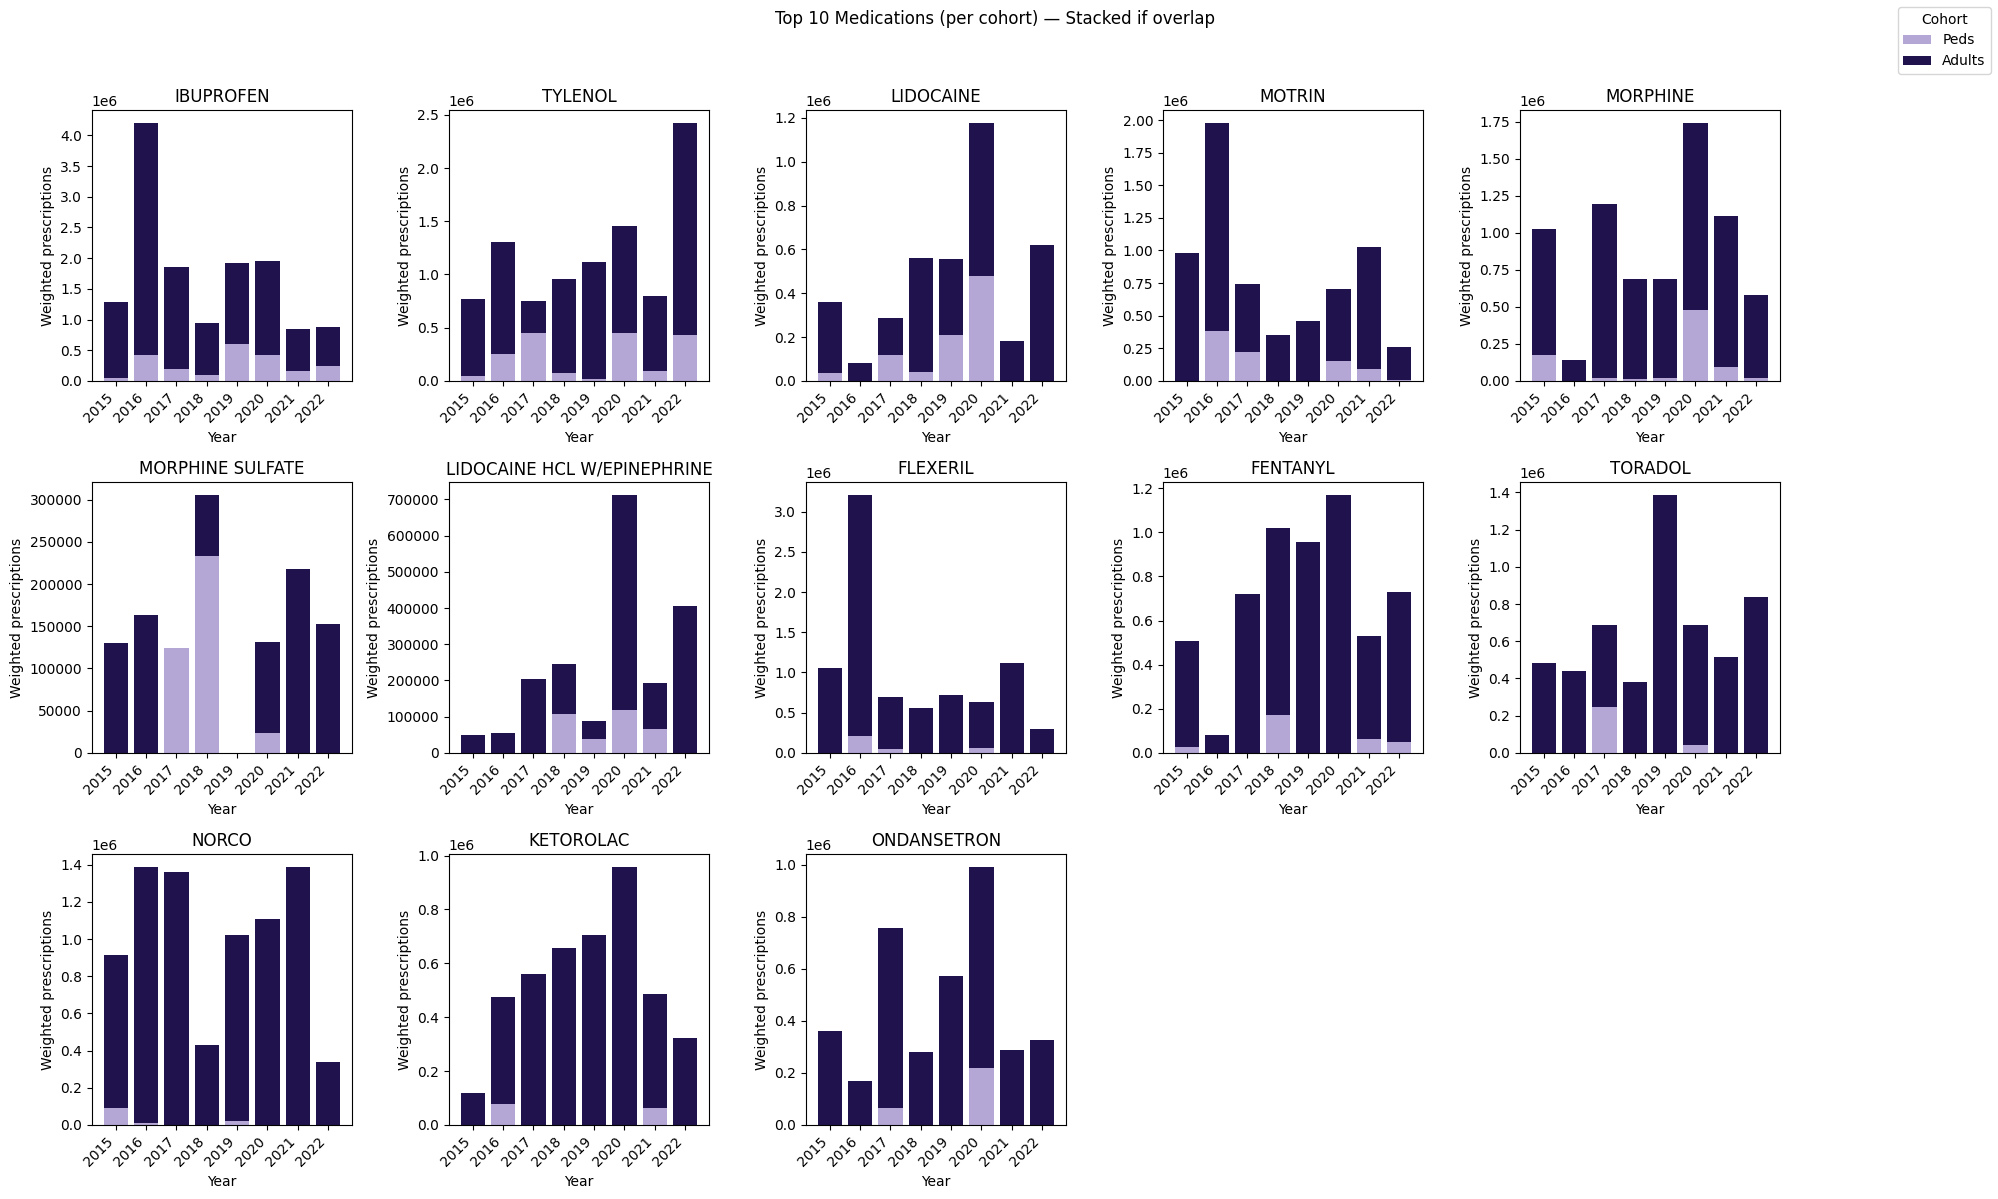

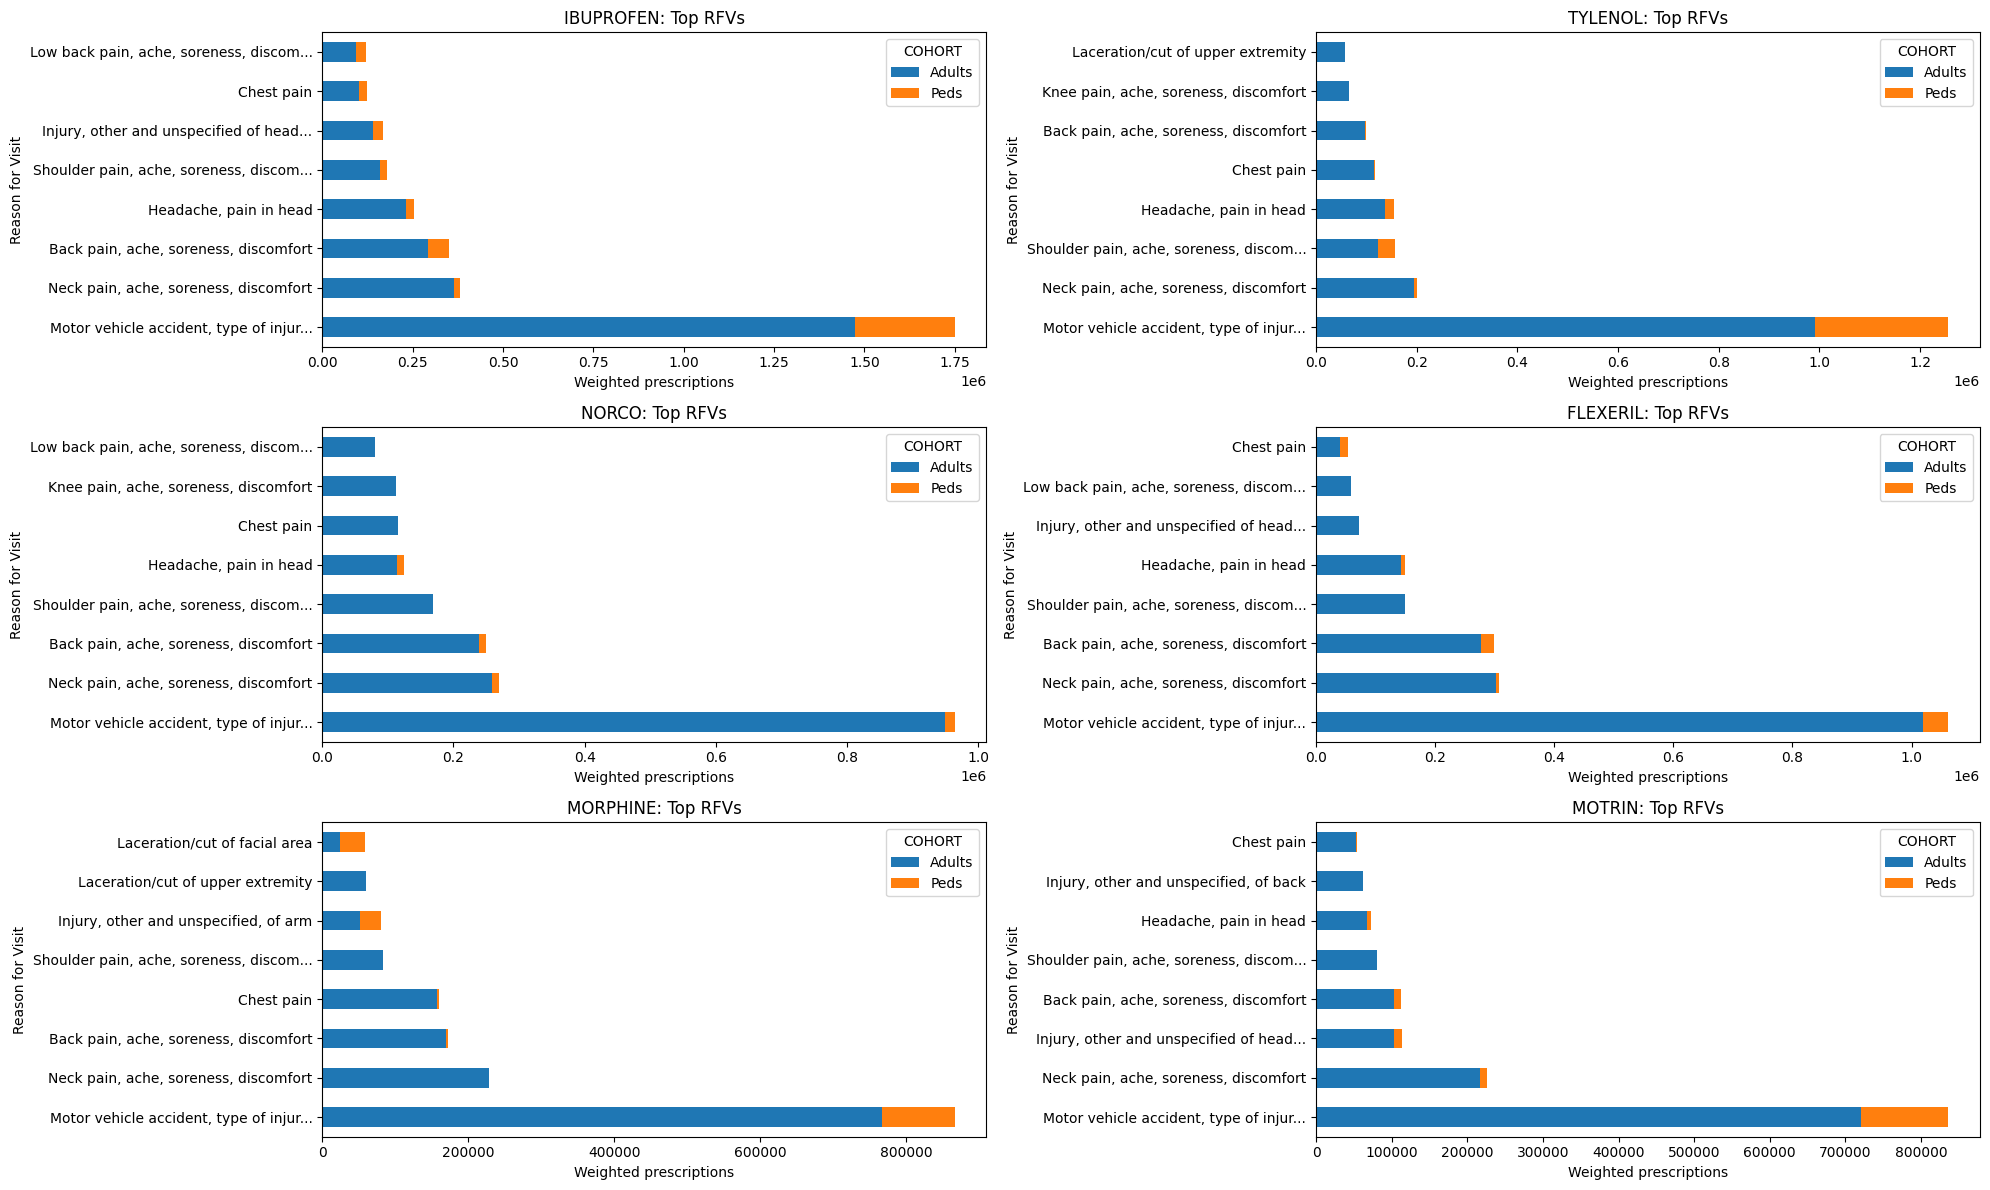

In [ ]:
# Yearly trend subplots, stacked if med appears in both Peds & Adults
plot_med_trends_year_stacked_if_overlap(peds_df, adults_df, top_k_meds=10, stop_terms_re=STOP_TERMS_RE)

# For each top med, show which RFVs drive its use (stacked by cohort)
plot_med_rfv_breakdown(peds_df, adults_df, top_k_meds=6, top_k_rfvs=8)


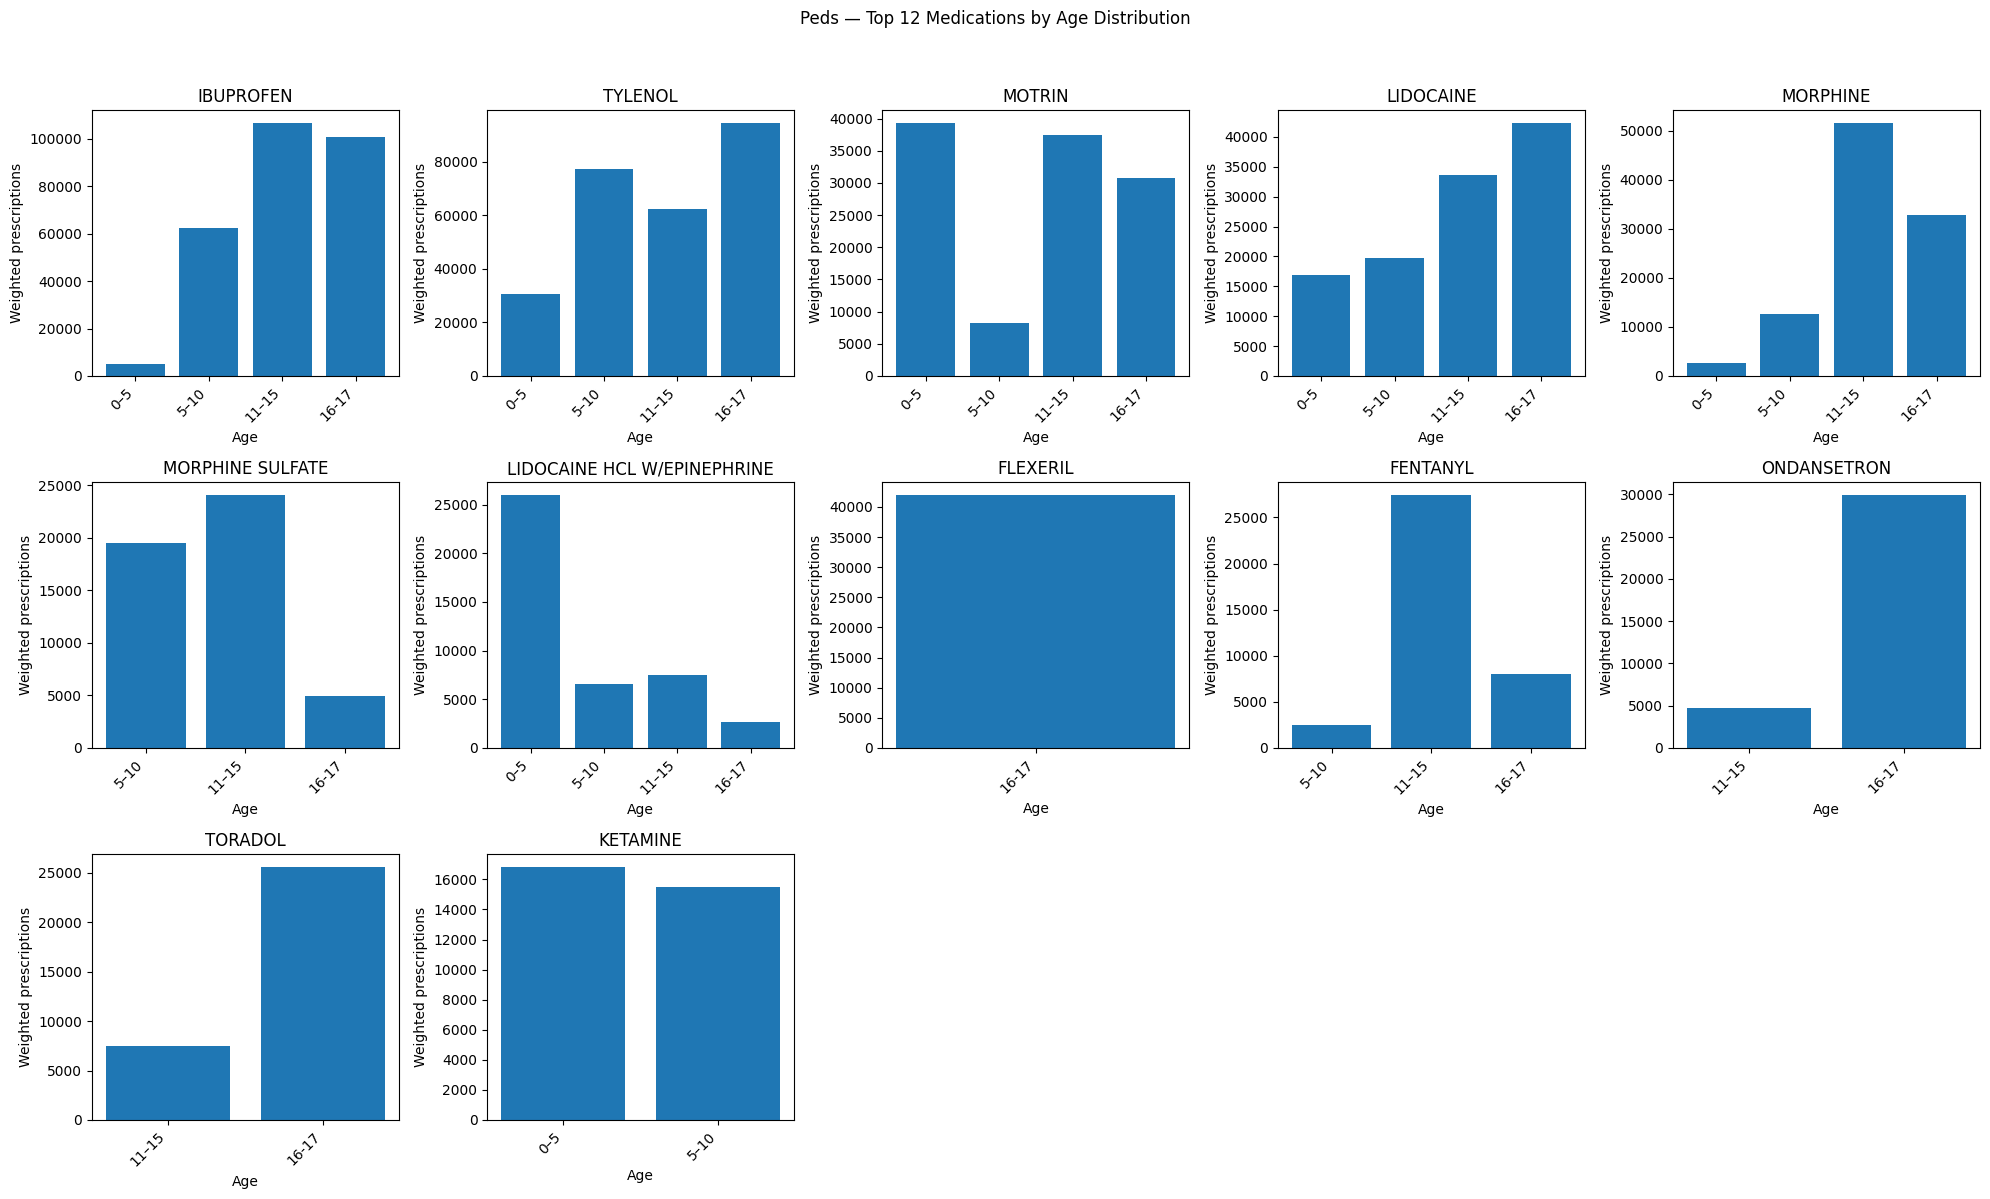

In [ ]:
from typing import Optional, List   

def _detect_med_cols(
    df: pd.DataFrame,
    med_prefix: str = "Med",
    med_cols: Optional[List[str]] = None,
    med_col_pattern: Optional[str] = None,
) -> List[str]:
    """
    Return list of medication column names from df using:
      1) explicit med_cols if provided
      2) regex med_col_pattern if provided (applied case-insensitively)
      3) fallback: columns that start with med_prefix (case/space-insensitive)
    """
    if med_cols:
        missing = [c for c in med_cols if c not in df.columns]
        if missing:
            raise ValueError(f"These med_cols were not found: {missing}")
        return med_cols

    cols = list(df.columns)

    # regex pattern path
    if med_col_pattern:
        rx = re.compile(med_col_pattern, re.IGNORECASE)
        found = [c for c in cols if rx.match(c.strip())]
        if found:
            return found
        
    mp = med_prefix.strip().lower()
    found = [c for c in cols if c.strip().lower().startswith(mp)]
    return found

def _build_med_age_agg_peds(
    peds: pd.DataFrame,
    age_col: str = "AGE",
    med_prefix: str = "Med",
    weight_col: str = "PATWT",
    stop_terms_re: Optional[re.Pattern] = None,
    age_bins: Optional[List[float]] = None,
    age_labels: Optional[List[str]] = None,
    *,
    med_cols: Optional[List[str]] = None,
    med_col_pattern: Optional[str] = r"^med\s*\d+$",  
):
    """
    Returns tidy DataFrame ['AGE_BIN','MED','weighted_count'] for pediatric records.
    """
    df = peds.copy()

    # Ensure numeric
    if weight_col not in df.columns:
        raise ValueError(f"Missing weight column '{weight_col}'")
    df[weight_col] = pd.to_numeric(df[weight_col], errors="coerce")

    if age_col not in df.columns:
        raise ValueError(f"Missing age column '{age_col}'")
    df[age_col] = pd.to_numeric(df[age_col], errors="coerce")

    if age_bins is None:
        age_bins = [0, 1, 5, 10, 15, 18]
    if age_labels is None:
        age_labels = ["<1", "1–4", "5–9", "10–14", "15–17"]

    df = df[(df[age_col] >= age_bins[0]) & (df[age_col] < age_bins[-1])]
    df = df.dropna(subset=[age_col, weight_col])

    med_cols_found = _detect_med_cols(
        df, med_prefix=med_prefix, med_cols=med_cols, med_col_pattern=med_col_pattern
    )
    if not med_cols_found:
        sample = df.columns[:20].tolist()
        raise ValueError(
            f"No medication columns detected. "
            f"Tried pattern='{med_col_pattern}', prefix='{med_prefix}'. "
            f"Top columns sample: {sample}\n"
            f"Tip: pass med_cols=[...] or adjust med_col_pattern."
        )

    long = df.melt(
        id_vars=[age_col, weight_col],
        value_vars=med_cols_found,
        var_name="MED_COL",
        value_name="MED",
    )

    # Clean med names
    long["MED"] = long["MED"].astype(str).str.strip()
    long = long.replace({"": np.nan, "nan": np.nan, "None": np.nan}).dropna(subset=["MED"])

    if stop_terms_re is None and "STOP_TERMS_RE" in globals():
        stop_terms_re = STOP_TERMS_RE
    if stop_terms_re is not None:
        long = long[~long["MED"].str.match(stop_terms_re, na=False)]

    # Bin ages
    long["AGE_BIN"] = pd.cut(
        long[age_col],
        bins=age_bins,
        labels=age_labels,
        right=False,
        include_lowest=True,
    ).astype("category")

    long = long.dropna(subset=["AGE_BIN"])

    # Group within each (AGE_BIN, MED) sum weights
    agg = (
        long.groupby(["AGE_BIN", "MED"], observed=True)[weight_col]
            .sum()
            .reset_index(name="weighted_count")
    )
    agg["AGE_BIN"] = pd.Categorical(agg["AGE_BIN"], categories=age_labels, ordered=True)
    return agg

def plot_med_age_distribution_peds(
    peds: pd.DataFrame,
    top_k_meds: int = 10,
    age_col: str = "AGE",
    med_prefix: str = "Med",
    weight_col: str = "PATWT",
    stop_terms_re: Optional[re.Pattern] = None,
    age_bins: Optional[List[float]] = None,
    age_labels: Optional[List[str]] = None,
    *,
    med_cols: Optional[List[str]] = None,
    med_col_pattern: Optional[str] = r"^med\s*\d+$",
):
    """
    Peds only: find top_k meds overall (weighted), then bar chart across age bins.
    """
    agg = _build_med_age_agg_peds(
        peds=peds,
        age_col=age_col,
        med_prefix=med_prefix,
        weight_col=weight_col,
        stop_terms_re=stop_terms_re,
        age_bins=age_bins,
        age_labels=age_labels,
        med_cols=med_cols,
        med_col_pattern=med_col_pattern,
    )
    if agg.empty:
        print("No pediatric data to plot after cleaning.")
        return

    # Top meds overall
    top_meds = (
        agg.groupby("MED")["weighted_count"]
           .sum()
           .sort_values(ascending=False)
           .head(top_k_meds)
           .index
           .tolist()
    )
    sub = agg[agg["MED"].isin(top_meds)].copy()

    if age_labels is None:
        age_labels = list(sub["AGE_BIN"].cat.categories)

    ncols = 5
    nrows = -(-len(top_meds) // ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows), squeeze=False)

    for i, med in enumerate(top_meds):
        r, c = divmod(i, ncols)
        ax = axes[r, c]

        row = sub[sub["MED"] == med].copy()
        row = row.set_index("AGE_BIN").reindex(age_labels).reset_index()

        ax.bar(row["AGE_BIN"].astype(str), row["weighted_count"])
        ax.set_title(med)
        ax.set_xlabel("Age")
        ax.set_ylabel("Weighted prescriptions")
        for lbl in ax.get_xticklabels():
            lbl.set_rotation(45)
            lbl.set_horizontalalignment("right")

    for j in range(len(top_meds), nrows*ncols):
        r, c = divmod(j, ncols)
        axes[r, c].axis("off")

    fig.suptitle(f"Peds — Top {len(top_meds)} Medications by Age Distribution", y=0.995)
    plt.tight_layout(rect=[0,0,1,0.97])
    plt.show()

plot_med_age_distribution_peds(
    peds_df,
    top_k_meds=12,
    age_col="AGE",          
    med_prefix="Med",       
    weight_col="PATWT",
    stop_terms_re=STOP_TERMS_RE,  
    age_bins=[0, 5, 12, 16, 18],
    age_labels=["0–5", "5–10", "11–15", "16-17"]

)
